In [1]:
import tensorflow as tf

In [2]:
# constant 사용법, Session과 run이 필요함 학습
tensor1 = tf.constant(3.0)
sess = tf.Session()
print sess.run(tensor1)

3.0


In [3]:
# tensor는 어떠한 rank, shape도 가능
tensor1 = tf.constant([1,2])
sess = tf.Session()
print sess.run(tensor1)

[1 2]


In [4]:
# operator에 대한 학습
tensor1 = tf.constant(3.0)
tensor2 = tf.constant(4.0)
tensor3 = tensor1 + tensor2
s = tf.Session()
print(s.run(tensor3))

7.0


In [5]:
graph = tf.get_default_graph()

In [6]:
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
# 텐서보드 사용
tf.reset_default_graph()
tensor1 = tf.constant(3.0, name='A')
tensor2 = tf.constant(4.0, name='B')
tensor3 = tensor1 + tensor2
# tensor4 = tf.add(tensor1, tensor2, name='addition')
s = tf.Session()
print(s.run(tensor3))
show_graph(tf.get_default_graph().as_graph_def())

7.0


In [8]:
# place holder 기본 사용법
tensor1 = tf.placeholder(tf.float32)
tensor2 = tf.placeholder(tf.float32)
tensor3 = tensor1 + tensor2
s = tf.Session()
s.run(tensor3, feed_dict = {tensor1:3, tensor2:4})  # 가변적인 부분을 여기서 조절, 인풋만 바뀔뿐 텐서플로내 변수가 바뀌진 않음

7.0

In [177]:
# reduce를 통한 차원줄이기(python에서 list에 sum()사용하는 것과 유사)
tensor1 = tf.placeholder(tf.float32, shape=(None))
tensor2 = tf.reduce_sum(tensor1)
s = tf.Session()
print s.run(tensor2, feed_dict = {tensor1:[1,2,3,4,5]})


3.0


In [178]:
# Variable 기초
# W, B등의 값을 반복적으로 값을 업데이트해 나가려면 Variable Tensor가 필요(feed dict로는 인풋의 다양성만 구현가능)
v = tf.Variable(1)
s = tf.Session()
s.run(v.initializer)  # Variable은 반드시 초기화 필요
# s.run(tf.global_variables_initializer())

print s.run(v)

1


In [152]:
# 변수값 업데이트를 위해서 assign operator 사용

tf.reset_default_graph()

V = tf.Variable(0, name = 'V')
one = tf.constant(1, name = '1')

s = tf.Session()
s.run(V.initializer)

V = V.assign(V + one)
print s.run(V)  # 연산결과로 나온 Tensor에 대해서 run()을 불러주면 값이 update 됨
print s.run(V)
print s.run(V)

show_graph(tf.get_default_graph().as_graph_def())

1
2
3


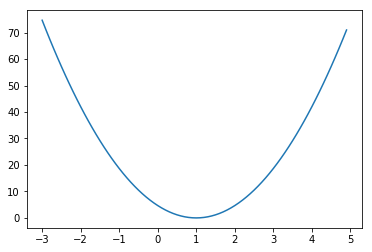

In [180]:
# Task: 기울기 W에 따른 최소제곱법 오차 추적
# 주의: 단순히 그래프만 그려볼 뿐 최적의 W값을 찾는 코드는 아님
import tensorflow as tf
import matplotlib.pyplot as plt
tf.reset_default_graph()

# 주어진 샘플
X = [1,2,3]
Y = [1,2,3]

W = tf.placeholder(tf.float32)
hypothesis = X * W  # 1차원 함수일것이라 생각하고 가설을 세운다.
cost = tf.reduce_mean(tf.square(hypothesis - Y))  # 가설(모델)과 주어진 샘플간 최소제곱법 오차가 기록되는 텐서
sess = tf.Session()
W_val = []
cost_val = []
for i in range(-30, 50):
    feed_W = i * 0.1
    curr_cost, curr_W = sess.run([cost, W], feed_dict={W:feed_W})  # 다양한 W인풋에 대한 오차를 계산
    W_val.append(curr_W)
    cost_val.append(curr_cost)
plt.plot(W_val, cost_val)
plt.show()
show_graph(tf.get_default_graph().as_graph_def())

In [190]:
# Task: cost를 최소화하는 W 찾기
# 아래코드는 방법1: 직접 Gradient를 계산하는 방법으로 구현
import tensorflow as tf
import matplotlib.pyplot as plt
tf.reset_default_graph()


x_data = [1,2,3]
y_data = [1,2,3]
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')
W = tf.Variable(tf.random_normal([1]), name='weight')

hypothesis = X * W
cost = tf.reduce_mean(tf.square(hypothesis - Y), name='cost')

learning_rate = 0.1
gradient = tf.reduce_mean((W*X-Y)*X, name='gradient')
descent = W - learning_rate * gradient
W_new = W.assign(descent)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(30):
    sess.run(W_new, feed_dict={X:x_data, Y:y_data})
    print step, sess.run(W), sess.run(cost, feed_dict={X:x_data, Y:y_data})


show_graph(tf.get_default_graph().as_graph_def())

0 [ 0.11684179] 3.63985
1 [ 0.52898228] 1.03534
2 [ 0.74879056] 0.294495
3 [ 0.86602163] 0.0837676
4 [ 0.92854488] 0.0238272
5 [ 0.96189064] 0.00677751
6 [ 0.97967499] 0.00192783
7 [ 0.98916] 0.000548361
8 [ 0.99421865] 0.000155978
9 [ 0.99691659] 4.43675e-05
10 [ 0.99835551] 1.26199e-05
11 [ 0.99912292] 3.58984e-06
12 [ 0.99953222] 1.02114e-06
13 [ 0.99975049] 2.90572e-07
14 [ 0.99986696] 8.25953e-08
15 [ 0.99992907] 2.34611e-08
16 [ 0.99996215] 6.68069e-09
17 [ 0.99997979] 1.90291e-09
18 [ 0.99998921] 5.44443e-10
19 [ 0.99999428] 1.52795e-10
20 [ 0.99999696] 4.27616e-11
21 [ 0.99999839] 1.18957e-11
22 [ 0.99999917] 3.05533e-12
23 [ 0.99999952] 1.06108e-12
24 [ 0.99999976] 2.65269e-13
25 [ 0.99999988] 9.9476e-14
26 [ 0.99999994] 2.4869e-14
27 [ 1.] 0.0
28 [ 1.] 0.0
29 [ 1.] 0.0


In [196]:
# Task: cost를 최소화하는 W 찾기
# 아래코드는 방법2: TensorFlow 내장 GradientDescentOpimizer 사용

import tensorflow as tf
import matplotlib.pyplot as plt
tf.reset_default_graph()

x_data = [1,2,3]
y_data = [1,2,3]
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')
W = tf.Variable(5.0, name='weight')

hypothesis = X * W
cost = tf.reduce_mean(tf.square(hypothesis - Y), name='cost')

min_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(10):
    print step, sess.run(W)
    sess.run(min_op, feed_dict={X:x_data, Y:y_data})

show_graph(tf.get_default_graph().as_graph_def())

0 5.0
1 1.26667
2 1.01778
3 1.00119
4 1.00008
5 1.00001
6 1.0
7 1.0
8 1.0
9 1.0


In [219]:
# Task: xor 문제 풀기
# 1단 레이어로는 안됨(linear regression)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.reset_default_graph()

x_data = np.array([[1,0], [0,1], [1,1], [0,0]], dtype=np.float32)
y_data = np.array([[1],[1],[0],[0]], dtype=np.float32)

X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')
W = tf.Variable(tf.random_normal([2,1]), name='weight')  # 2 in , 1 out
B = tf.Variable(tf.random_normal([1]), name='bias')  # bias는 항상 out수와 동일하게

hypothesis = tf.sigmoid(tf.matmul(X, W) + B)
cost = tf.reduce_mean(tf.square(hypothesis - Y), name='cost')
min_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

s = tf.Session()
s.run(tf.global_variables_initializer())

# train
for step in range(10001):
    s.run(min_op, feed_dict={X:x_data, Y:y_data})
    if step % 100 == 0:
        print step, s.run(cost, feed_dict={X:x_data, Y:y_data})

# test
h,c,a = s.run([hypothesis, predicted, accuracy], feed_dict={X:x_data, Y:y_data})
print 'hypothesis output',h
print 'correct',c
print 'accuracy',a

show_graph(tf.get_default_graph().as_graph_def())
                   


0 0.349608
100 0.305414
200 0.271971
300 0.260982
400 0.256792
500 0.254237
600 0.252624
700 0.251624
800 0.25101
900 0.250632
1000 0.250399
1100 0.250254
1200 0.250163
1300 0.250105
1400 0.250069
1500 0.250045
1600 0.25003
1700 0.25002
1800 0.250013
1900 0.250009
2000 0.250006
2100 0.250004
2200 0.250003
2300 0.250002
2400 0.250001
2500 0.250001
2600 0.250001
2700 0.25
2800 0.25
2900 0.25
3000 0.25
3100 0.25
3200 0.25
3300 0.25
3400 0.25
3500 0.25
3600 0.25
3700 0.25
3800 0.25
3900 0.25
4000 0.25
4100 0.25
4200 0.25
4300 0.25
4400 0.25
4500 0.25
4600 0.25
4700 0.25
4800 0.25
4900 0.25
5000 0.25
5100 0.25
5200 0.25
5300 0.25
5400 0.25
5500 0.25
5600 0.25
5700 0.25
5800 0.25
5900 0.25
6000 0.25
6100 0.25
6200 0.25
6300 0.25
6400 0.25
6500 0.25
6600 0.25
6700 0.25
6800 0.25
6900 0.25
7000 0.25
7100 0.25
7200 0.25
7300 0.25
7400 0.25
7500 0.25
7600 0.25
7700 0.25
7800 0.25
7900 0.25
8000 0.25
8100 0.25
8200 0.25
8300 0.25
8400 0.25
8500 0.25
8600 0.25
8700 0.25
8800 0.25
8900 0.25
9000 0.

In [218]:
# Task: xor 문제 풀기
# 1단 레이어로 딥하게 풀기
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.reset_default_graph()

x_data = np.array([[1,0], [0,1], [1,1], [0,0]], dtype=np.float32)
y_data = np.array([[1],[1],[0],[0]], dtype=np.float32)

X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')
W1 = tf.Variable(tf.random_normal([2,10]), name='weight1')  # 2 in , 2 out
B1 = tf.Variable(tf.random_normal([10]), name='bias1')  # bias는 항상 out수와 동일하게
layer1 = tf.sigmoid(tf.matmul(X, W1) + B1)

W2 = tf.Variable(tf.random_normal([10,1]), name='weight2')  # 2 in , 2 out
B2 = tf.Variable(tf.random_normal([1]), name='bias2')  # bias는 항상 out수와 동일하게
hypothesis = tf.sigmoid(tf.matmul(layer1, W2) + B2)

cost = tf.reduce_mean(tf.square(hypothesis - Y), name='cost')
min_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

s = tf.Session()
s.run(tf.global_variables_initializer())

# train
for step in range(10001):
    s.run(min_op, feed_dict={X:x_data, Y:y_data})
    if step % 100 == 0:
        print step, s.run(cost, feed_dict={X:x_data, Y:y_data})

# test
h,c,a = s.run([hypothesis, predicted, accuracy], feed_dict={X:x_data, Y:y_data})
print 'hypothesis output',h
print 'correct',c
print 'accuracy',a
show_graph(tf.get_default_graph().as_graph_def())

0 0.255858
100 0.244629
200 0.234011
300 0.224554
400 0.215985
500 0.207709
600 0.199344
700 0.190711
800 0.181749
900 0.172465
1000 0.162909
1100 0.153162
1200 0.143329
1300 0.133527
1400 0.12388
1500 0.114509
1600 0.105521
1700 0.0970039
1800 0.0890212
1900 0.0816117
2000 0.074791
2100 0.068555
2200 0.0628846
2300 0.0577495
2400 0.053113
2500 0.0489347
2600 0.0451733
2700 0.0417883
2800 0.0387413
2900 0.0359965
3000 0.033521
3100 0.0312853
3200 0.0292627
3300 0.0274296
3400 0.0257649
3500 0.0242502
3600 0.0228691
3700 0.0216071
3800 0.0204515
3900 0.0193912
4000 0.0184162
4100 0.017518
4200 0.0166888
4300 0.0159218
4400 0.015211
4500 0.0145511
4600 0.0139374
4700 0.0133657
4800 0.0128321
4900 0.0123334
5000 0.0118665
5100 0.0114288
5200 0.0110178
5300 0.0106313
5400 0.0102675
5500 0.00992449
5600 0.00960072
5700 0.00929475
5800 0.00900521
5900 0.00873096
6000 0.00847089
6100 0.008224
6200 0.00798937
6300 0.0077662
6400 0.00755371
6500 0.00735121
6600 0.00715804
6700 0.00697364
6800 0